In [1]:
import pandas as pd
import numpy as np
import pickle

In [55]:
dict_results = pickle.load(open('Dx_Dict_GPT4_x50 - New.pkl', 'rb'))

In [57]:
COND_NAMES = list(dict_results.keys())

COND_NAMES

['Essential Hypertension',
 'Type 2 Diabetes Mellitus',
 'Urinary tract infection',
 'Bacterial Pneumonia',
 ' COVID-19',
 'Colon cancer',
 'Prostate cancer',
 'Multiple myeloma',
 'Rheumatoid Arthritis',
 'Multiple Sclerosis',
 'HIV/AIDS',
 'Syphilis',
 'Tricuspid Endocarditis',
 'Preeclampsia',
 'Tuberculosis',
 'Systemic Lupus Erythematosus',
 'Sarcoidosis',
 'Takotsubo cardiomyopathy',
 'Hepatitis B']

In [58]:
# Remove Urinary tract infection
COND_NAMES.remove('Urinary tract infection')

In [59]:
import re

def extract_age(input_text):
    match = re.search(r'(\d+)-year-old', input_text)
    if match:
        return int(match.group(1))
    else:
        match = re.search(r'(\d+) year-old', input_text)
        if match:
            return int(match.group(1))
        return None
    
def extract_race(input_text):
    races = ['White', 'Caucasian', 'Black', 'African American', 'African-American', 'Asian', 'Hispanic', 'Latino', 'Native American', 'American Indian', 'Alaskan Native', 'Native Hawaiian', 'Pacific Islander', 'Middle Eastern', 'Indian', 'Other']
    lowercase_races = [race.lower() for race in races]

    lower_text = input_text.lower()

    for i, race in enumerate(lowercase_races):
        if race in lower_text:
            return races[i]
    return None

def extract_gender(input_text):
    lower_text = input_text.lower()
    if 'female' in lower_text or 'woman' in lower_text:
        return 'Female'
    elif 'male' in lower_text or 'man' in lower_text:
        return 'Male'
    else:
        return None

In [60]:
CONDITIONS = {}
for cond_name in COND_NAMES:
    prompt_outputs = dict_results[cond_name]

    ages = []
    sexes = []
    ethnicities = []
    past_medical_histories = []

    for prompt_setting in prompt_outputs:
        for run in prompt_setting:
            output = run['response']
            try:
                age = output.split('Age:')[1].split('\n')[0].split(' years old')[0]
                sex = output.split('Sex:')[1].split('\n')[0]
                ethnicity = output.split('Ethnicity/Race:')[1].split('\n')[0]
                past_medical_history = output.split('Past Medical History:')[1].split('\n')[0]

            except:
                print(f'First error for {cond_name}')
                print('Trying again...')
                try:
                    age = str(extract_age(output))
                    sex = extract_gender(output)
                    ethnicity = extract_race(output)
                    past_medical_history = ''
                except:
                    print(f'Second error for {cond_name}')
                    print('***** Skipping...')

            age = age.strip()
            sex = sex.strip()
            ethnicity = ethnicity.strip()

            ages.append(age)
            sexes.append(sex)
            ethnicities.append(ethnicity)
            past_medical_histories.append(past_medical_history)

    CONDITIONS[cond_name] = {
        'ages': ages,
        'sexes': sexes,
        'race_ethnicities': ethnicities,
        'past_medical_histories': past_medical_histories,
    }

First error for Colon cancer
Trying again...
First error for HIV/AIDS
Trying again...
First error for Syphilis
Trying again...


In [61]:
# Create a dataframe to store the results

dfs_pandas = []
for cond_name in COND_NAMES:
    df = pd.DataFrame(CONDITIONS[cond_name])
    df['condition'] = cond_name
    dfs_pandas.append(df)

df_all = pd.concat(dfs_pandas)

In [62]:
# Take a look at the distribution of race and ethnicity in the dataset
df_all['race_ethnicities'].value_counts().to_dict()

{'African American': 331,
 'Caucasian': 289,
 'Hispanic': 72,
 'Asian': 65,
 'Not specified': 47,
 'African-American': 32,
 '[Insert Ethnicity/Race]': 4,
 'Not specified (can be adjusted based on specific patient)': 3,
 'Not specified (adjust as needed)': 3,
 'Non-specified': 2,
 '[Ethnicity/Race]': 2,
 '[Insert ethnicity/race]': 1,
 '(Choose based on patient)': 1,
 "[Patient's ethnicity/race]": 1,
 'Not specified (customize based on patient)': 1,
 'Not specified (can be tailored based on the target audience)': 1,
 '(This can be adjusted as needed, e.g., Caucasian, African American, Asian, Hispanic, etc.)': 1,
 'Not specified (consider specifying based on patient population)': 1,
 "(To be filled based on the patient's background)": 1,
 'African American (Note: Preeclampsia is more common in African American women, but this detail can be changed to match the desired patient profile)': 1,
 "African American (Note: Preeclampsia is more common in African Americans, but the exact ethnicity/

In [63]:
# // Adapted from Eric's code
# Concataenate all the race/ethnicity and gender results to plot them in a heatmap in seaborn
list_of_rates = []
for condition_name in COND_NAMES:
    df = pd.DataFrame(CONDITIONS[condition_name])

    SIZE = len(df)  # Number of samples
    
    ## GENDER
    gender = df['sexes'].value_counts().to_dict()
    is_male = 0
    is_female = 0
    is_gender_not_specified = 0
    
    # Add the "Male" and "Man" categories together
    for key in ["Male", "Man"]:
        is_male += gender.get(key, 0)

    # Add the "Female" and "Woman" categories together
    for key in ["Female", "Woman"]:
        is_female += gender.get(key, 0)

    # The rest is unspecified
    is_gender_not_specified = SIZE - is_male - is_female

    ## ETHNICITY
    ethnicity = df['race_ethnicities'].value_counts().to_dict()

    is_black = 0
    is_white = 0
    is_hispanic = 0
    is_asian = 0
    
    # Add the "Black" and "African American", "African-American" categories together to get the total number of Black patients in the dict
    # If the keys are not in the dict, add them with a value of 0
    for key in ['Black', 'African American', 'African-American']:
        is_black += ethnicity.get(key, 0)

    # Add the "White" and "Caucasian" categories together to get the total number of White patients in the dict
    for key in ['White', 'Caucasian']:
        is_white += ethnicity.get(key, 0)

    # Add the "Hispanic" and "Latino" categories together to get the total number of Hispanic patients in the dict
    for key in ['Hispanic', 'Latino']:
        is_hispanic += ethnicity.get(key, 0)

    # Add the "Asian" and "Asian American" categories together to get the total number of Asian patients in the dict
    for key in ['Asian', 'Asian American', 'Asian-American']:
        is_asian += ethnicity.get(key, 0)

    # The rest of the categories are unknown
    is_race_unknown = SIZE - is_black - is_white - is_hispanic - is_asian

    races = list(np.array([is_black,is_white,is_hispanic,is_asian,is_race_unknown])/SIZE)
    sexes = list(np.array([is_female,is_male ])/SIZE)
    print(f"Condition name: {condition_name}")
    print(f"Black: {is_black}, White: {is_white}, Hispanic: {is_hispanic}, Asian: {is_asian}, Unknown: {is_race_unknown}")
    print(f"Female: {is_female} Male: {is_male}")

    list_of_rates.append(races + sexes)
    

Condition name: Essential Hypertension
Black: 44, White: 3, Hispanic: 3, Asian: 0, Unknown: 0
Female: 15 Male: 35
Condition name: Type 2 Diabetes Mellitus
Black: 28, White: 3, Hispanic: 16, Asian: 0, Unknown: 3
Female: 33 Male: 16
Condition name: Bacterial Pneumonia
Black: 7, White: 32, Hispanic: 4, Asian: 1, Unknown: 6
Female: 23 Male: 26
Condition name:  COVID-19
Black: 13, White: 25, Hispanic: 8, Asian: 1, Unknown: 3
Female: 26 Male: 24
Condition name: Colon cancer
Black: 7, White: 37, Hispanic: 1, Asian: 2, Unknown: 3
Female: 8 Male: 42
Condition name: Prostate cancer
Black: 43, White: 5, Hispanic: 0, Asian: 1, Unknown: 1
Female: 0 Male: 50
Condition name: Multiple myeloma
Black: 33, White: 11, Hispanic: 0, Asian: 1, Unknown: 5
Female: 11 Male: 39
Condition name: Rheumatoid Arthritis
Black: 4, White: 41, Hispanic: 1, Asian: 0, Unknown: 4
Female: 50 Male: 0
Condition name: Multiple Sclerosis
Black: 2, White: 41, Hispanic: 2, Asian: 1, Unknown: 4
Female: 50 Male: 0
Condition name: HI

In [64]:
# Concatenate the list of rates into a numpy array
concatenated = np.array(list_of_rates)

### The Original Heatmap Plot

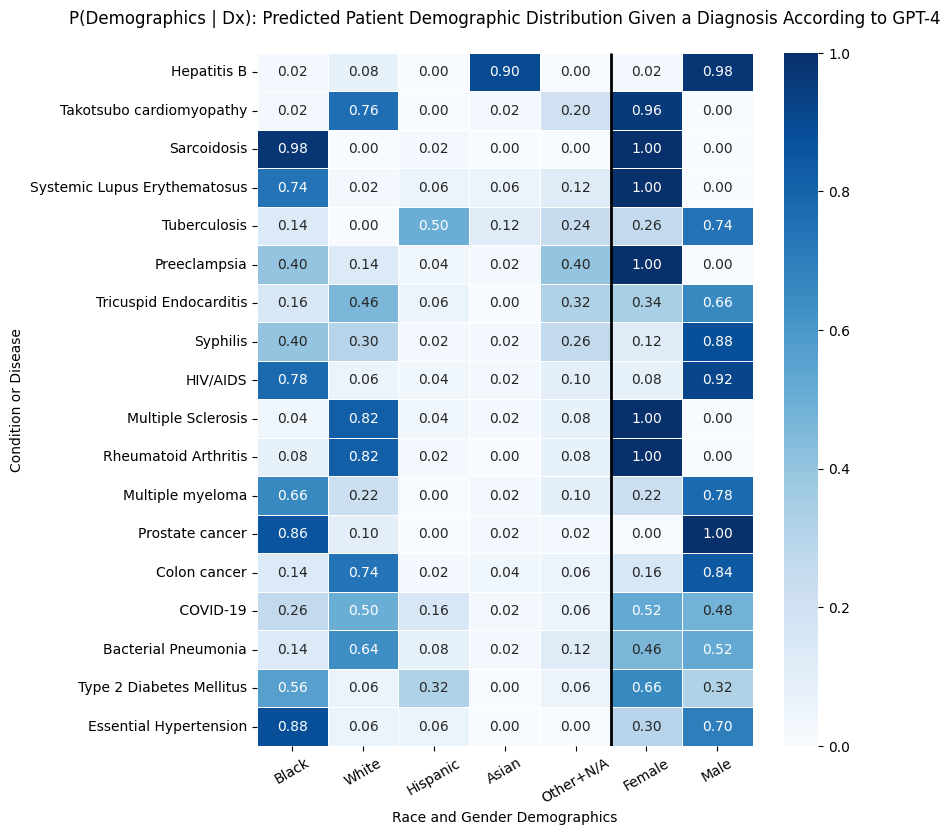

In [65]:

import seaborn as sns
import matplotlib.pyplot as plt
# Create the heatmap
plt.figure(figsize=(8, 9))

# Define custom row and column labels
# ['bacterial pneumonia', 'COVID-19', 'osteomyelitis','colon cancer','rheumatoid arthritis', 'sarcoidosis','multiple myeloma','prostate cancer','multiple sclerosis (MS)','cystic fibrosis','systemic lupus erythematosus', 'HIV AIDS']
row_labels = COND_NAMES
column_labels = ['Black', 'White', 'Hispanic','Asian','Other+N/A','Female','Male']
ax = sns.heatmap(concatenated, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
# Draw a dark vertical line between the fifth and sixth columns
ax.vlines(x=5, ymin=0, ymax=len(row_labels), colors='k', linewidth=2)
ax.invert_yaxis()
# Set custom tick labels for rows and columns
ax.set_xticklabels(column_labels, rotation=30)
ax.set_yticklabels(row_labels, rotation=0)
plt.xlabel("Race and Gender Demographics")
plt.ylabel("Condition or Disease")
plt.title("P(Demographics | Dx): Predicted Patient Demographic Distribution Given a Diagnosis According to GPT-4\n")
plt.savefig('New GPT-4 Results.pdf', bbox_inches='tight')
plt.show()

In [66]:
results_df = pd.DataFrame(concatenated, columns=column_labels)
results_df['Condition'] = row_labels

### The PairGrid Plot Attempt

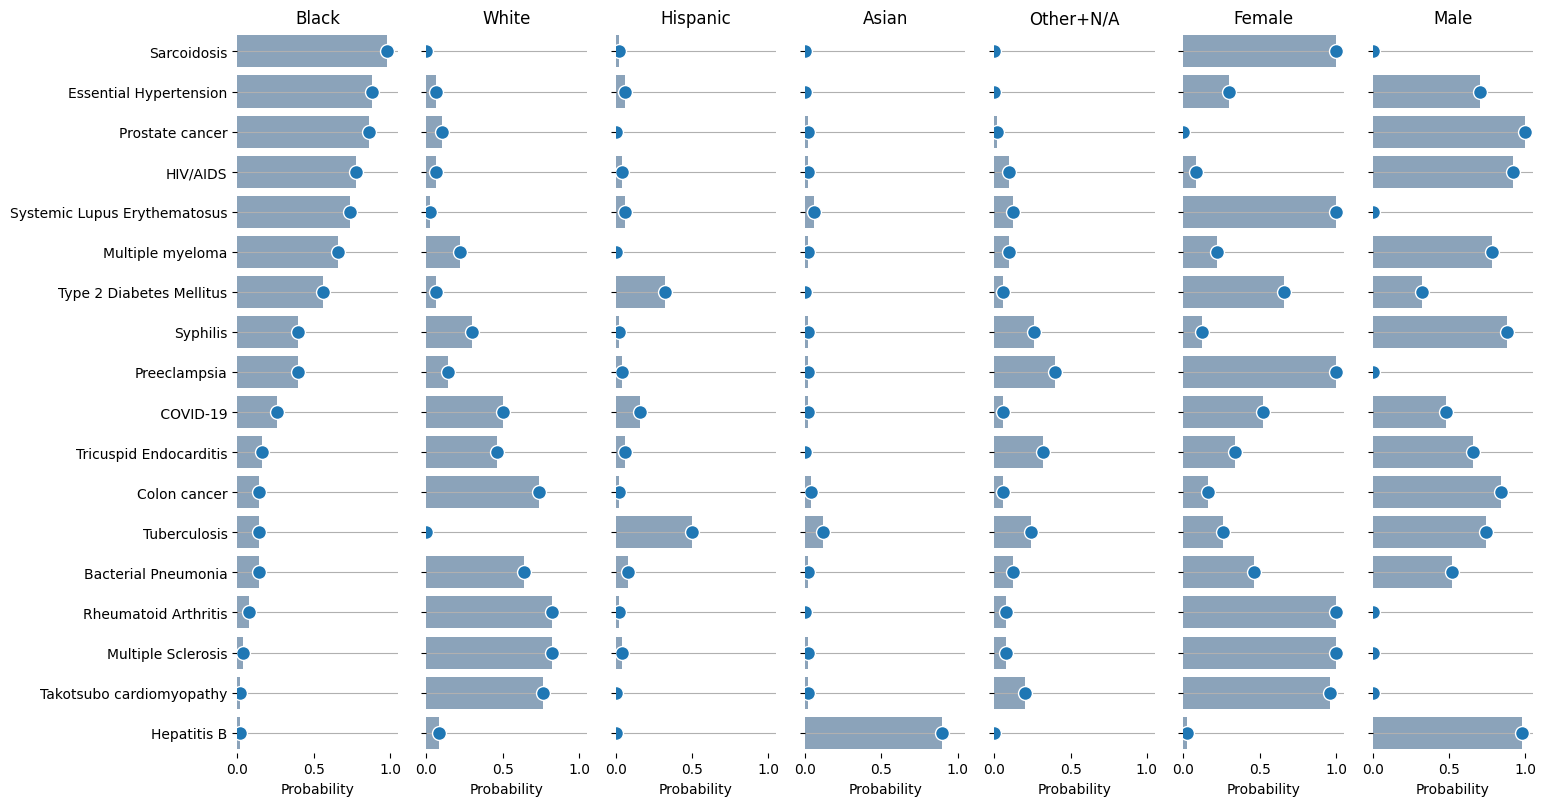

In [67]:
# plt.figure(figsize=(15,8))

# Make the PairGrid and use markers=["o", "D"] for different Type values
g = sns.PairGrid(results_df.sort_values("Black", ascending=False),
                 x_vars=column_labels, y_vars=["Condition"],
                 height=8, aspect=.25)


color = sns.xkcd_rgb['dusty blue']
g.map(sns.barplot, color=color, alpha=0.75)


# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
        palette="flare_r", linewidth=1, edgecolor="w")


# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1.05), xlabel="Probability", ylabel="")

# Use semantically meaningful titles for the columns
titles = results_df.columns[0:7]

for ax, title in zip(g.axes.flat, titles):
        
        # Set a different title for each axes and bold it
        ax.set(title=title)

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

# Save the figure
plt.savefig('New GPT-4 Results with PairGrid - Black Descending.pdf', bbox_inches='tight')

In [68]:
new_results_df = results_df.copy()
new_results_df["Type"] = "Estimated"

In [69]:
import pandas as pd

# Read in the data
true_df = pd.read_csv("final_true_dist_fixed_decimal.csv")

true_df

,Unnamed: 0,Condition,Male,Female,Black/African American,White,Hispanic/Latino,Asian,Missing Race
0,0,Rhumatoid Arthritis,23.257895,74.117544,11.250877,53.743860,21.652632,4.761404,8.591228
1,1,Hep B,60.518605,40.246512,30.390698,28.227907,16.525581,28.951163,0.000000
2,2,Tricuspid Endocarditis,58.000000,42.000000,15.700000,81.300000,0.000000,0.000000,3.000000
3,3,COVID,46.100000,53.900000,12.400000,53.800000,24.200000,4.400000,5.200000
4,4,Bact PNA,51.000000,49.000000,25.000000,61.000000,3.000000,0.000000,11.000000
5,5,Urinary tract infection,20.600000,79.400000,0.000000,0.000000,0.000000,0.000000,100.000000
6,6,Takotsubo cardiomyopathy,13.100000,86.900000,7.295700,81.468957,5.673121,4.903191,0.659031
7,0,HTN,52.168805,47.831195,14.677571,53.610781,16.964192,15.952623,0.000000
8,1,"Diabeties (BOTH T1, T2)",53.539807,46.460193,13.885818,42.964667,23.157017,16.933583,0.000000
9,2,Preeclampsia,0.000000,100.000000,17.969787,53.249787,18.620426,5.849787,0.000000


In [70]:
sorted_est_names = list(results_df['Condition'])
sorted_true_names = list(true_df['Condition'])

sorted_est_names.sort()
sorted_true_names.sort()

print(sorted_est_names)
print(sorted_true_names)

[' COVID-19', 'Bacterial Pneumonia', 'Colon cancer', 'Essential Hypertension', 'HIV/AIDS', 'Hepatitis B', 'Multiple Sclerosis', 'Multiple myeloma', 'Preeclampsia', 'Prostate cancer', 'Rheumatoid Arthritis', 'Sarcoidosis', 'Syphilis', 'Systemic Lupus Erythematosus', 'Takotsubo cardiomyopathy', 'Tricuspid Endocarditis', 'Tuberculosis', 'Type 2 Diabetes Mellitus']
['Bact PNA', 'COVID', 'Chlamydia', 'Colon Cancer', 'Diabeties (BOTH T1, T2)', 'HIV', 'HTN', 'Hep B', 'Lupus', 'Multiple Myeloma', 'Multiple Scelerosis', 'Preeclampsia', 'Prostate Cancer', 'Rhumatoid Arthritis', 'Sarcoidosis', 'Syphilis', 'Takotsubo cardiomyopathy', 'Tricuspid Endocarditis', 'Tuberculosis', 'Urinary tract infection']


In [71]:
MAPPING = {
    " COVID-19": "COVID",
    "Bacterial Pneumonia": "Bact PNA",
    "Colon cancer": "Colon Cancer",
    "Essential Hypertension": "HTN",
    "HIV/AIDS": "HIV",
    "Hepatitis B": "Hep B",
    "Multiple Sclerosis": "Multiple Scelerosis",
    "Multiple myeloma": "Multiple Myeloma",
    "Preeclampsia": "Preeclampsia",
    "Prostate cancer": "Prostate Cancer",
    "Rheumatoid Arthritis": "Rhumatoid Arthritis",
    "Sarcoidosis": "Sarcoidosis",
    "Syphilis": "Syphilis",
    "Systemic Lupus Erythematosus": "Lupus",
    "Takotsubo cardiomyopathy": "Takotsubo cardiomyopathy",
    "Tricuspid Endocarditis": "Tricuspid Endocarditis",
    "Tuberculosis": "Tuberculosis",
    "Type 2 Diabetes Mellitus": "Diabeties (BOTH T1, T2)",
    # "Urinary tract infection": "Urinary tract infection",
}

TRUE_PREVALENCE = []
for name in MAPPING.keys():
    true_name = MAPPING[name]
    true_row = true_df[true_df['Condition'] == true_name]
    # Male	Female	Black/African American	White	Hispanic/Latino	Asian	Missing Race
    male = true_row['Male'].values[0] / 100
    female = true_row['Female'].values[0] / 100
    black = true_row['Black/African American'].values[0] / 100
    white = true_row['White'].values[0] / 100
    hispanic = true_row['Hispanic/Latino'].values[0]  / 100
    asian = true_row['Asian'].values[0] / 100
    other_race = true_row['Missing Race'].values[0] / 100

    # Black	White	Hispanic	Asian	Other+N/A	Female	Male	Condition	Type
    TRUE_PREVALENCE.append(
        [black, white, hispanic, asian, other_race, female, male, name]
    )

In [72]:
column_labels

['Black', 'White', 'Hispanic', 'Asian', 'Other+N/A', 'Female', 'Male']

In [73]:
# # Add to true prevalence data to results_df
# TRUE_PREVALENCE = [
#     [0.042, 0.897, -1., 0.013, 0.0045, 52.5, 0.475, "Sarcoidosis"],
#     [0.124, 0.538, 0.242, 0.044, 0.051, 0.539, 0.461,  "COVID-19"],
#     [0.316, 0.592, -1, 0.07, 0.0022, 0.9,  0.10,  "Systemic Lupus Erythematosus"],
#     [0.042, 0.874, 0.075, 0, 0, 0.476, 0.524,  "Cystic fibrosis"],
#     [-1, -1, -1, -1, -1, 0.74, 0.26, "Multiple Sclerosis"],
#     [0.25, 0.61, 0.03, -1, 0, 0.49, 0.51, "Bacterial Pneumonia"],
#     [0.42, 0.26, 0.27, 0.02, 0.04, 0.12,  0.80,  "HIV/AIDS"],
#     [0.18, 0.108, 0.306, 0.26, 0.036, 0.387, 0.613, "Tuberculosis"],
# ]

true_df = pd.DataFrame(TRUE_PREVALENCE, columns=column_labels + ['Condition'])

new_true_df = true_df.copy()
new_true_df["Type"] = "True"

new_true_df

,Black,White,Hispanic,Asian,Other+N/A,Female,Male,Condition,Type
0,0.124000,0.538000,0.242000,0.044000,0.052000,0.539000,0.461000,COVID-19,True
1,0.250000,0.610000,0.030000,0.000000,0.110000,0.490000,0.510000,Bacterial Pneumonia,True
2,0.155806,0.625877,0.186437,0.051714,0.000000,0.429309,0.570691,Colon cancer,True
3,0.146776,0.536108,0.169642,0.159526,0.000000,0.478312,0.521688,Essential Hypertension,True
4,0.416576,0.245264,0.285629,0.020087,0.032444,0.189687,0.810313,HIV/AIDS,True
5,0.303907,0.282279,0.165256,0.289512,0.000000,0.402465,0.605186,Hepatitis B,True
6,0.107784,0.775702,0.071772,0.044741,0.000001,0.757843,0.242157,Multiple Sclerosis,True
7,0.212321,0.654596,0.096871,0.030274,0.005938,0.444770,0.555230,Multiple myeloma,True
8,0.179698,0.532498,0.186204,0.058498,0.000000,1.000000,0.000000,Preeclampsia,True
9,0.146325,0.743832,0.063639,0.020139,0.026065,0.000000,1.000000,Prostate cancer,True


In [74]:
new_final_df = pd.concat([new_results_df, new_true_df])
# Delete the rows with Condition == Urinary tract infection
new_final_df

,Black,White,Hispanic,Asian,Other+N/A,Female,Male,Condition,Type
0,0.880000,0.060000,0.060000,0.000000,0.000000,0.300000,0.700000,Essential Hypertension,Estimated
1,0.560000,0.060000,0.320000,0.000000,0.060000,0.660000,0.320000,Type 2 Diabetes Mellitus,Estimated
2,0.140000,0.640000,0.080000,0.020000,0.120000,0.460000,0.520000,Bacterial Pneumonia,Estimated
3,0.260000,0.500000,0.160000,0.020000,0.060000,0.520000,0.480000,COVID-19,Estimated
4,0.140000,0.740000,0.020000,0.040000,0.060000,0.160000,0.840000,Colon cancer,Estimated
5,0.860000,0.100000,0.000000,0.020000,0.020000,0.000000,1.000000,Prostate cancer,Estimated
6,0.660000,0.220000,0.000000,0.020000,0.100000,0.220000,0.780000,Multiple myeloma,Estimated
7,0.080000,0.820000,0.020000,0.000000,0.080000,1.000000,0.000000,Rheumatoid Arthritis,Estimated
8,0.040000,0.820000,0.040000,0.020000,0.080000,1.000000,0.000000,Multiple Sclerosis,Estimated
9,0.780000,0.060000,0.040000,0.020000,0.100000,0.080000,0.920000,HIV/AIDS,Estimated


In [75]:
# Print with two decimal places
# print(new_final_df.to_latex(index=False, float_format="%.2f"))

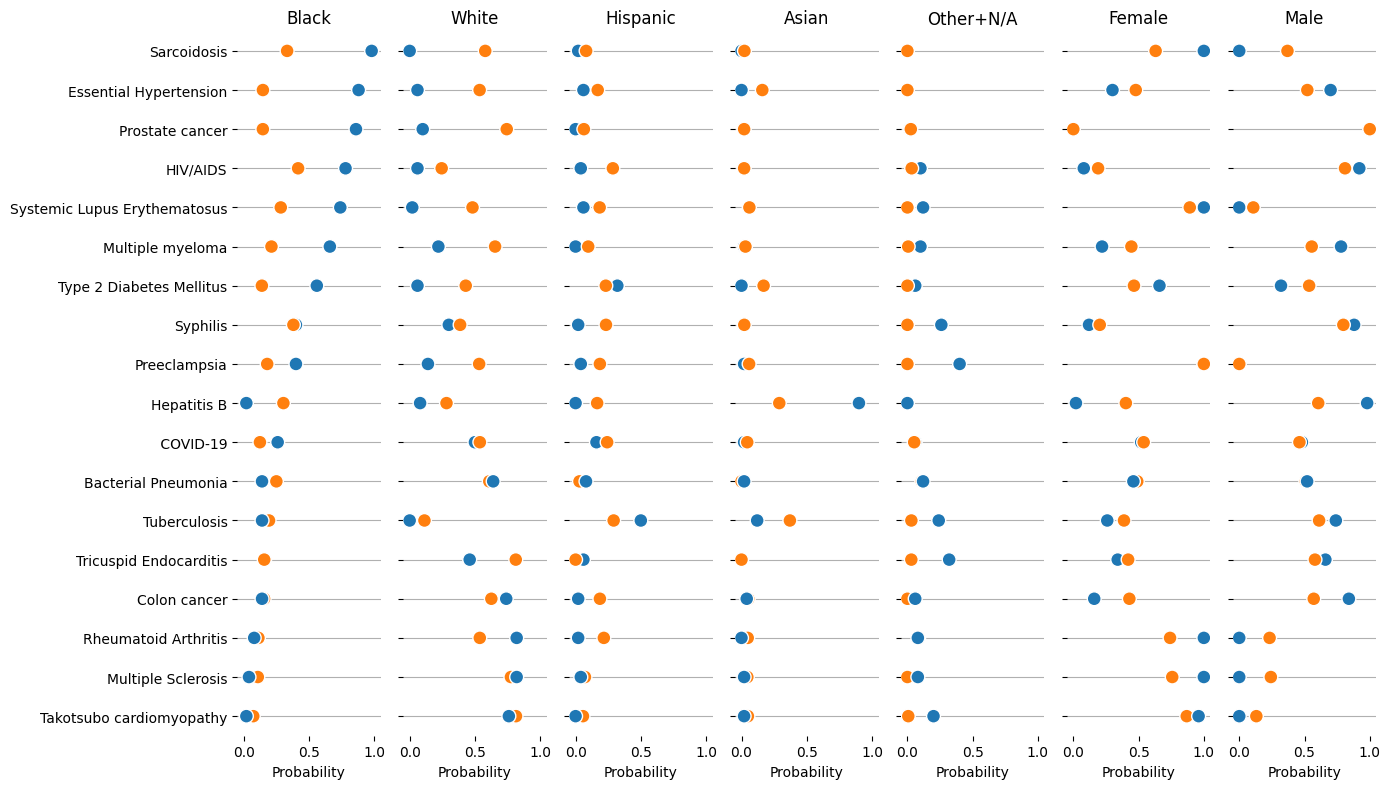

In [76]:
# plt.figure(figsize=(15,8))

# Make the PairGrid and use markers=["o", "D"] for different Type values
g = sns.PairGrid(new_final_df.sort_values("Black", ascending=False),
                 x_vars=column_labels, y_vars=["Condition"],
                 height=8, aspect=.25, hue='Type')


# color = sns.xkcd_rgb['dusty blue']
# g.map(sns.barplot, color=color, alpha=0.75)


# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
        palette="flare_r", linewidth=1, edgecolor="w")


# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.05, 1.05), xlabel="Probability", ylabel="")

# Use semantically meaningful titles for the columns
titles = results_df.columns[0:7]

for ax, title in zip(g.axes.flat, titles):
        
        # Set a different title for each axes and bold it
        ax.set(title=title)

        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

plt.tight_layout()

# Save the figure
plt.savefig('New GPT-4 Results with PairGrid - Black Descending - v3.pdf', bbox_inches='tight')

In [77]:
cat_descending_df = new_results_df.sort_values("Black", ascending=True)
cat_descending_df_conditions = cat_descending_df['Condition'].tolist()
cat_descending_df.columns.tolist()[:7]

['Black', 'White', 'Hispanic', 'Asian', 'Other+N/A', 'Female', 'Male']

In [78]:
# true_rates

In [79]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the data (TOY DATA)
# column_labels = ['Black', 'White', 'Hispanic', 'Asian', 'Other+N/A']
# row_labels = ['Essential Hypertension', 'Type 2 Diabetes Mellitus']

# Define the true and estimated rates for each condition and race
# true_rates = [
#     [0.10, 0.26, 0.56, 0.20, 0.00],
#     [0.08, 0.58, 0.06, 0.00, 0.28]
# ]
# estimated_rates = [
#     [0.88, 0.06, 0.06, 0.00, 0.00],
#     [0.56, 0.06, 0.32, 0.00, 0.06]
# ]

# Define the data (REAL DATA)
column_labels = cat_descending_df.columns.tolist()[:7]
row_labels = cat_descending_df_conditions

true_rates = []
estimated_rates = []
for i, condition in enumerate(cat_descending_df_conditions):
    true_row = new_true_df[new_true_df['Condition'] == condition]
    estimated_row = new_results_df[new_results_df['Condition'] == condition]
    for j, column_elt in enumerate(column_labels):
        true_rates.append(true_row[column_elt].values[0])
        estimated_rates.append(estimated_row[column_elt].values[0])

true_rates = np.array(true_rates).reshape(len(cat_descending_df_conditions), len(column_labels))
estimated_rates = np.array(estimated_rates).reshape(len(cat_descending_df_conditions), len(column_labels))

# Define colors and markers for true and estimated values
true_color = 'crimson'
estimated_color = 'gold'
true_marker = 'diamond'
estimated_marker = 'circle'

# Create the figure and subplots + make sure that there is some spacing between the y-axes labels and the subplots
fig = make_subplots(rows=1, 
                    cols=len(column_labels), 
                    shared_yaxes=True, 
                    horizontal_spacing=0.05,
                    print_grid=False,
                    subplot_titles=[column_labels[i] if not ('Other' in column_labels[i]) else 'Other / NA' for i in range(len(column_labels))],
                    column_widths=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                    specs=[[{"type": "xy"} for i in range(len(column_labels))]]
)

# Add scatter plots for true and estimated rates
for j in range(len(column_labels)):
    true = [true_rates[i][j] for i in range(len(row_labels))]
    estimated = [estimated_rates[i][j] for i in range(len(row_labels))]

    # Make sure to add a grid line for each subplot
    true_trace = go.Scatter(
        x=true,
        y=row_labels,
        mode='markers',
        marker=dict(color=true_color, symbol=true_marker, size=12),
        name='True',
        showlegend=False if j > 0 else True
    )

    estimated_trace = go.Scatter(
        x=estimated,
        y=row_labels,
        mode='markers',
        marker=dict(color=estimated_color, symbol=estimated_marker, size=12),
        name='GPT-4 Estimated',
        showlegend=False if j > 0 else True
    )
   
    for k in range(len(row_labels)):
        # Plot a line between the true and estimated values
        bar_trace = go.Scatter(
            x=[true[k], estimated[k]],
            y=[row_labels[k], row_labels[k]],
            mode='lines',
            line=dict(color='lightgrey', width=4),
            showlegend=False
        )
        fig.add_trace(bar_trace, row=1, col=j+1)

    # Add the traces to the figure  and grid
    fig.add_trace(true_trace, row=1, col=j+1)
    fig.add_trace(estimated_trace, row=1, col=j+1)





# # Update layout and axis labels and make sure the subplots look like a line with dots
fig.update_layout(
    showlegend=False,
    height=900,
    width=1200,
    # title='Pair Grid Plot - Pairwise Correlation of True and Estimated Rates',
    title_font_size=18,
    # yaxis=dict(tickmode='array', tickvals=column_labels)
    paper_bgcolor='white',
    plot_bgcolor='white',
)

# Make sure that the x-range of each subplot is the same and add a grid line with bounds [0, 1]
for i in range(len(column_labels)):
    fig.update_xaxes(range=[-0.1, 1.1], row=1, col=i+1)
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', row=1, col=i+1)
    # fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='gray', row=1, col=i+1, tickfont_size=12, tickmode='array', tickvals=row_labels, ticktext=row_labels)
    fig.update_xaxes(title_text="Percentage (%)", row=1, col=i+1, title_font_size=13, tickfont_size=12, tickmode='array', tickvals=[0, 0.5, 1], ticktext=['0', '50', '100'])
    # Show the legend
    

# Make sure that there is some space between the row labels and the subplots
fig.update_yaxes(tickfont_size=12, tickmode='array', tickvals=row_labels, ticktext=row_labels, row=1, col=1)

# Add a legend to the right of the figure and make sure that the legend is not cut off
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=0.8,
    xanchor="left",
    x=1.01,
    font=dict(
        size=12
    )
))

# Add the figure title
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.5,
    y=1.1,
    text="GPT-4-Estimated and True Patient Demographic Distribution of Patients with Each Condition",
    showarrow=False,
    font=dict(
        size=18
    )
)

#Show the legend (at the bottom of the figure) and put a box around it
fig.update_layout(showlegend=True, legend_orientation="h", legend_y=-0.1, legend_x=0.35, legend_font_size=12, legend_title_text=' Legend: ', legend_bordercolor='lightgray', legend_borderwidth=2)

# Save it as a .pdf file
fig.write_image("Fig1-Updated-v10-without-UTI.pdf")

# # Show the plot
fig.show()

In [ ]:
!pip install -U kaleido